# scVIVA for representing cells and their environment in spatial transcriptomics
In this tutorial, we go through the steps of training scVIVA, a deep generative model that leverages both cell-intrinsic and neighboring gene expression profiles to produce stochastic embeddings of cell states as well as normalized gene expression profiles. We show how to obtain informative fine-grained partitions of cells that reflects both their internal state and the surrounding tissue and use the generative model to test hypotheses of differential expression between tissue niches.

Plan for this tutorial:

1. Loading the data
2. Training a scVIVA model
3. Visualizing the latent space
4. Perform DE analysis across niches

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# Install from GitHub for now
!pip install --quiet scvi-colab
!pip install --quiet adjustText
from scvi_colab import install

install()

/home/nathanl/miniforge3/envs/scvi/lib/python3.12/site-packages/scvi_colab/_core.py:47: UserWarning: 
                Not currently in Google Colab environment.

                Please run with `run_outside_colab=True` to override.

                Returning with no further action.
                
  warn(


In [3]:
import os
import random
import tempfile

import numpy as np  # type: ignore
import scanpy as sc  # type: ignore
import scvi  # type: ignore
import torch  # type: ignore
from rich import print  # type: ignore

sc.set_figure_params(figsize=(4, 4))
save_dir = tempfile.TemporaryDirectory()
%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}
%config InlineBackend.figure_format='retina'

scvi.settings.seed = 0
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
print("Last run with scvi-tools version:", scvi.__version__)

Seed set to 0


Last run with scvi-tools version: 1.3.1

In [ ]:
# Quickly check the correct folder is used.
scvi.__file__

'/home/nathanl/scvi-tools-main/src/scvi/__init__.py'

## Data loading

In this tutorial we load a human breast cancer section, generated with [10X Xenium](https://www.nature.com/articles/s41467-023-43458-x). 
The cell segmentation originally performed on this data resulted in many erroneously assigned transcripts and therefore re-segmented the cells using the [ProSeg](https://www.biorxiv.org/content/10.1101/2024.04.25.591218v1) algorithm, which is a scalable algorithm for transcriptome-informed segmentation.

In [5]:
adata_path = os.path.join(save_dir.name, "xenium_tutorial.h5ad")
adata = sc.read(
    adata_path,
    backup_url="https://figshare.com/ndownloader/files/53178338",
)
adata

  0%|          | 0.00/1.11G [00:00<?, ?B/s]

AnnData object with n_obs × n_vars = 117305 × 313
    obs: 'sample', 'x', 'y', 'z', 'observed_x', 'observed_y', 'observed_z', 'fov', 'n_counts', 'index', 'cell_type'
    var: 'mt'
    uns: '_scvi_manager_uuid', '_scvi_uuid', 'log1p', 'pca'
    obsm: 'X_pca', 'X_scANVI', 'spatial'
    varm: 'PCs'
    layers: 'counts', 'counts_log1p', 'counts_wo_bg', 'min_max_scaled', 'min_max_scaled_raw'

The authors identified distinct tumor domains in this specimen, corresponding to in situ ductal carcinoma (DCIS) and invasive tumor:

/tmp/ipykernel_678351/2186789331.py:1: FutureWarning: Use `squidpy.pl.spatial_scatter` instead.
  sc.pl.spatial(adata, color="cell_type", spot_size=30)


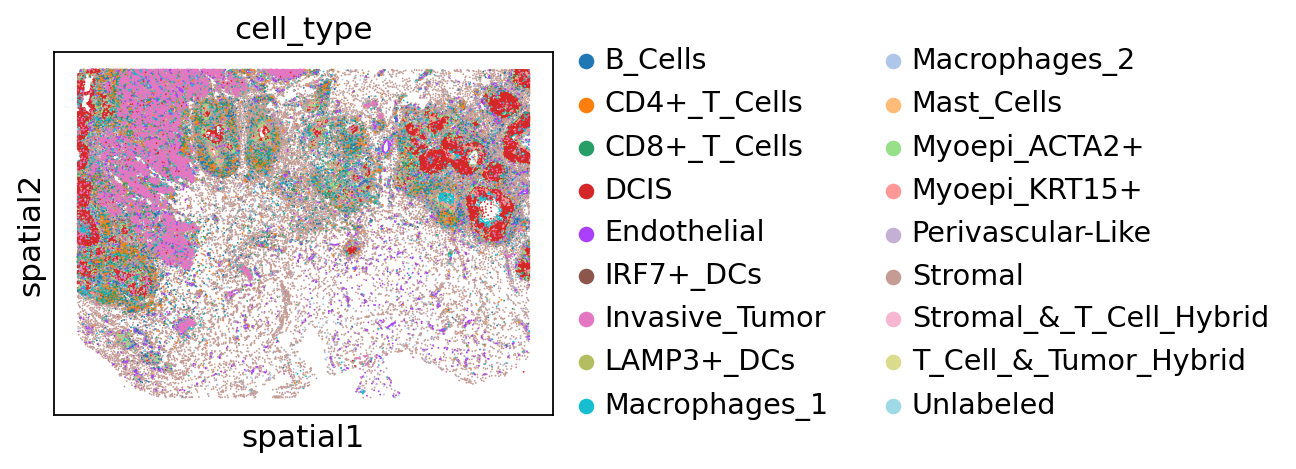

In [6]:
sc.pl.spatial(adata, color="cell_type", spot_size=30)

In [7]:
adata.obs["cell_type"].value_counts()

cell_type
Stromal                    32426
Invasive_Tumor             18185
DCIS                       15993
CD4+_T_Cells                9387
Macrophages_1               8644
CD8+_T_Cells                7493
Endothelial                 7000
B_Cells                     5359
Myoepi_ACTA2+               5324
Myoepi_KRT15+               2636
Macrophages_2               2616
Perivascular-Like            817
Unlabeled                    516
IRF7+_DCs                    454
LAMP3+_DCs                   218
Mast_Cells                   203
Stromal_&_T_Cell_Hybrid       28
T_Cell_&_Tumor_Hybrid          6
Name: count, dtype: int64

## Train scVIVA model

We first define the neighborhood of each cell using a k-nn graph. We set $k=20$. Then, the environment features are defined in two ways - the first is the cell-type composition of its cellular neighborhood. The second is the average gene expression state of neighboring cells, with a separate profile for each of the present cell types. These cell-intrinsic gene expression states can be learned with a spatially unaware model such as scANVI, or with resolVI. 

Here we assume that scANVI has already been trained on the data, and that the embeddings are stored in the AnnData object. We refer to the scANVI tutorial for training the model.


Environment features computations occur in the `preprocessing_anndata` method, that adds the relevant keys to the AnnData object. 

In [8]:
setup_kwargs = {
    "sample_key": "sample",  # column in adata.obs that contains the individual slide ID
    "labels_key": "cell_type",  # column in adata.obs that contains the cell type labels
    "cell_coordinates_key": "spatial",  # spatial coordinates key in adata.obsm
    "expression_embedding_key": "X_scANVI",  # expression embedding key in adata.obsm
}

In [9]:
scvi.external.SCVIVA.preprocessing_anndata(
    adata,
    k_nn=20,  # number of nearest neighbors for spatial graph construction
    **setup_kwargs,
)

Saved niche_indexes and niche_distances in adata.obsm

Saved niche_composition in adata.obsm

Saved niche_activation in adata.obsm

Then, as in all scvi-tools model, we need to register the AnnData.

In [10]:
scvi.external.SCVIVA.setup_anndata(
    adata,
    layer="counts",  # adata layer that contains the raw counts
    batch_key="sample",  # column in adata.obs that contains the batch covariate
    **setup_kwargs,
)

INFO     Using column names from columns of adata.obsm['niche_composition']                                        
INFO     Generating sequential column names                                                                        
INFO     Generating sequential column names                                                                        
INFO     Generating sequential column names                                                                        
INFO     Generating sequential column names                                                                        
INFO     Generating sequential column names                                                                        


We instantiate a scVIVA model:

In [11]:
nichevae = scvi.external.SCVIVA(adata)

nichevae

scVIVA model with the following parameters: 
n_hidden: 128, n_latent: 10, n_layers: 1, dropout_rate: 0.1, dispersion: gene, gene_likelihood: poisson, 
latent_distribution: normal.
Training status: Not Trained
Model's adata is minified?: False

In [12]:
nichevae.train(
    max_epochs=600,
    early_stopping=True,
    check_val_every_n_epoch=1,
    batch_size=512,
    plan_kwargs={
        "lr": 5e-4,
    },
)

Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 4090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/nathanl/miniforge3/envs/scvi/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottlen

Training:   0%|          | 0/600 [00:00<?, ?it/s]

Monitored metric elbo_validation did not improve in the last 45 records. Best score: 238.879. Signaling Trainer to stop.


We can plot the training curves:

In [13]:
nichevae.history.keys()

dict_keys(['kl_weight', 'train_loss_step', 'validation_loss', 'elbo_validation', 'reconstruction_loss_validation', 'kl_local_validation', 'kl_global_validation', 'niche_compo_validation', 'niche_reconst_validation', 'train_loss_epoch', 'elbo_train', 'reconstruction_loss_train', 'kl_local_train', 'kl_global_train', 'niche_compo_train', 'niche_reconst_train'])

Let's plot for instance the validation ELBO, niche composition and state losses:

<Axes: xlabel='epoch'>

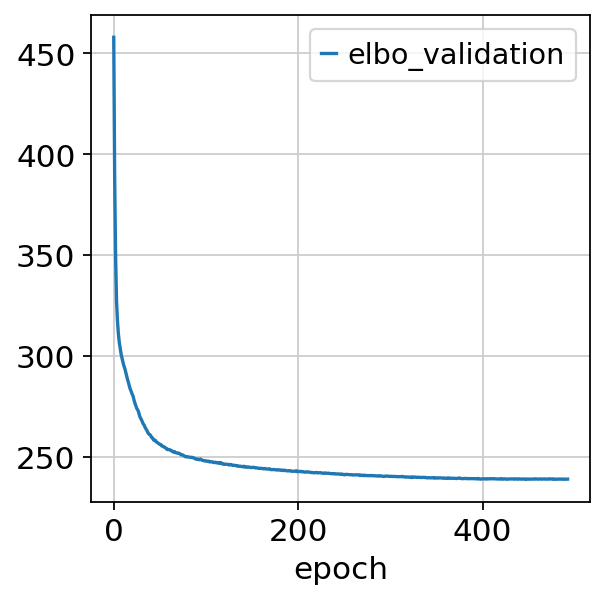

In [14]:
nichevae.history["elbo_validation"].plot()

<Axes: xlabel='epoch'>

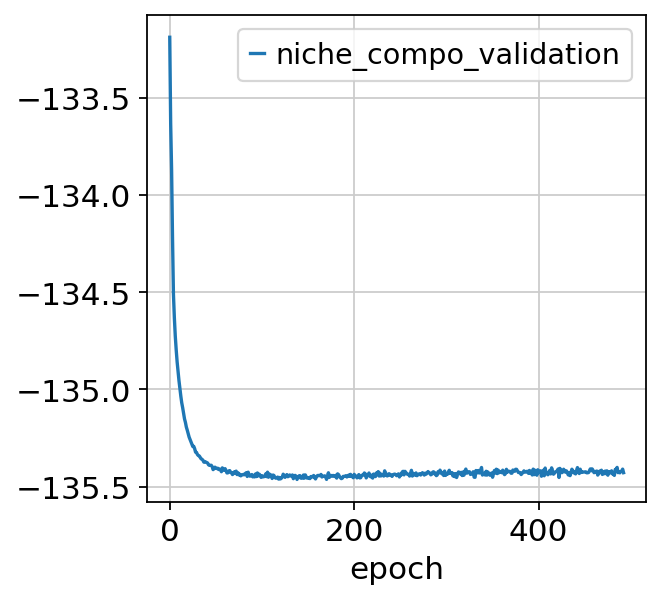

In [15]:
nichevae.history["niche_compo_validation"].plot()

<Axes: xlabel='epoch'>

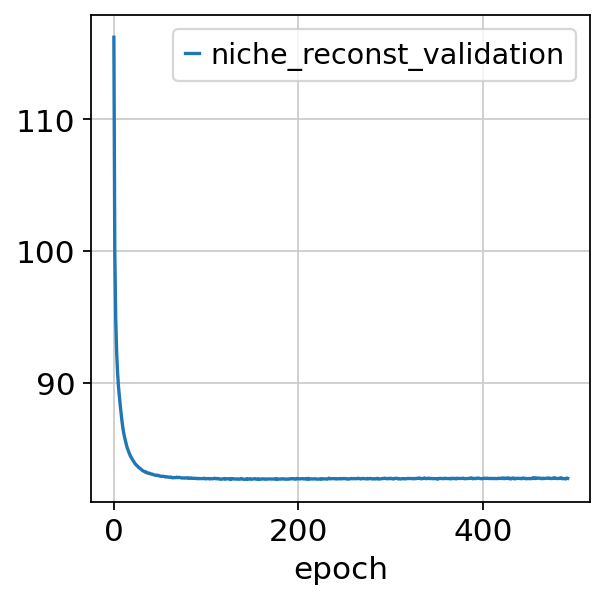

In [17]:
nichevae.history["niche_reconst_validation"].plot()

<Axes: xlabel='epoch'>

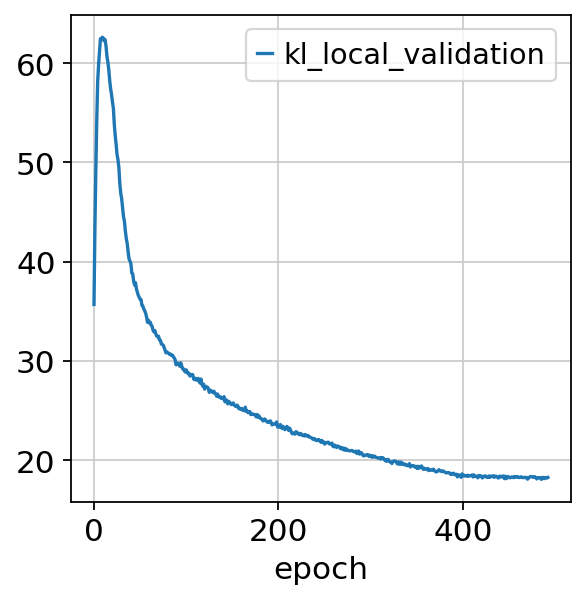

In [18]:
nichevae.history["kl_local_validation"].plot()

<Axes: xlabel='epoch'>

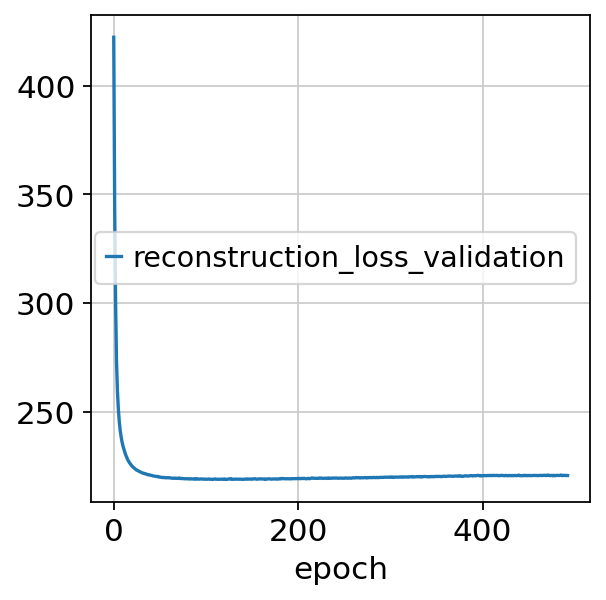

In [19]:
nichevae.history["reconstruction_loss_validation"].plot()

After training the model, we can compute and store the latent space: 

In [17]:
adata.obsm["X_scVIVA"] = nichevae.get_latent_representation()

We may visualize the latent space in UMAP coordinates, coloring by cell type. 

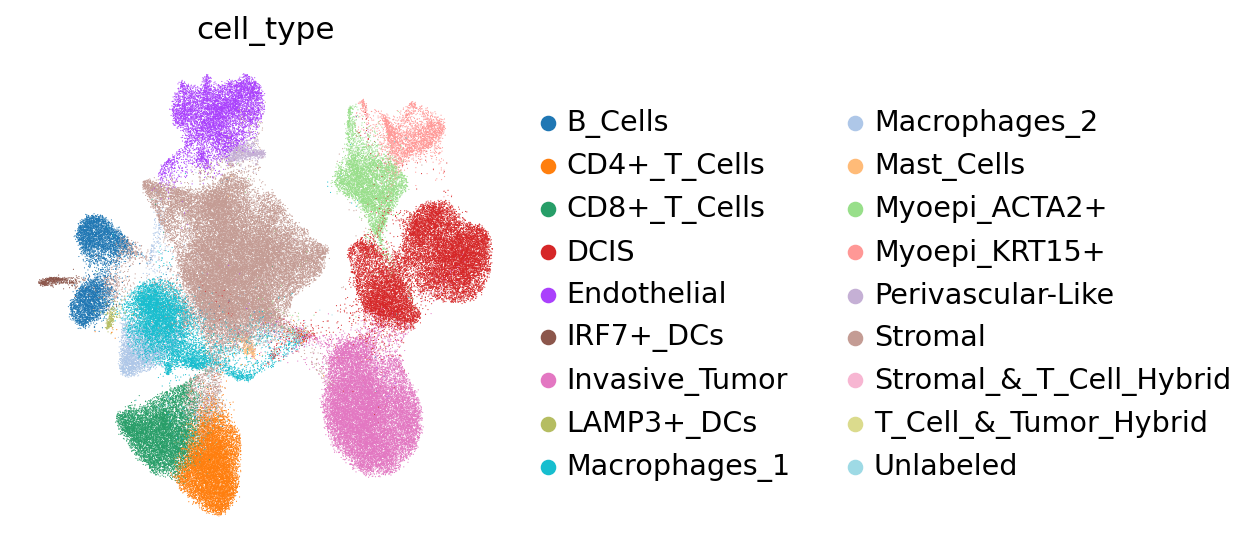

In [18]:
sc.pp.neighbors(adata, use_rep="X_scVIVA", n_neighbors=30)
sc.tl.umap(adata)

sc.pl.umap(adata, color="cell_type", frameon=False)

# Differential expression analysis

We now use the generative model to test hypotheses of differential expression between the niches. We'll focus on endothelial cells. 

In [19]:
adata_endothelial = adata[adata.obs["cell_type"] == "Endothelial"].copy()
adata_not_endo = adata[adata.obs["cell_type"] != "Endothelial"].copy()

print(adata_endothelial)

AnnData object with n_obs × n_vars = 7000 × 313
    obs: 'sample', 'x', 'y', 'z', 'observed_x', 'observed_y', 'observed_z', 'fov', 'n_counts', 'index', 
'cell_type', '_scvi_batch', '_scvi_labels', '_scvi_sample'
    var: 'mt'
    uns: '_scvi_manager_uuid', '_scvi_uuid', 'log1p', 'pca', 'cell_type_colors', 'neighbors', 'umap'
    obsm: 'X_pca', 'X_scANVI', 'spatial', 'niche_indexes', 'niche_distances', 'niche_composition', 
'niche_activation', 'X_scVIVA', 'X_umap'
    varm: 'PCs'
    layers: 'counts', 'counts_log1p', 'counts_wo_bg', 'min_max_scaled', 'min_max_scaled_raw'
    obsp: 'distances', 'connectivities'

We perform coarse Leiden clustering on the endothelial latent space, in a bid to find spatially confined populations of endothelial cells.

In [20]:
sc.pp.neighbors(adata_endothelial, use_rep="X_scVIVA", n_neighbors=30, random_state=42)
sc.tl.umap(adata_endothelial)
sc.tl.leiden(
    adata_endothelial,
    key_added="leiden_scVIVA",
    resolution=0.3,
    flavor="igraph",
    n_iterations=-1,
    random_state=42,
)

In [21]:
adata_endothelial.obs["leiden_scVIVA"].unique()  # check the number of clusters

['0', '1', '4', '2', '3']
Categories (5, object): ['0', '1', '2', '3', '4']

We focus on clusters 0 and 1, which are located in the stromal and tumor regions, respectively. We then perform differential expression analysis between these two clusters.

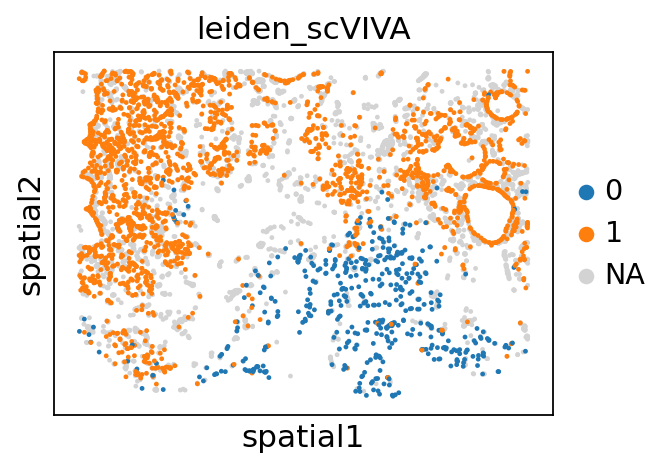

In [22]:
sc.pl.spatial(
    adata_endothelial,
    color="leiden_scVIVA",
    spot_size=80,
    groups=["1", "0"],
)

In [23]:
adata.obs["leiden_scVIVA"] = "Unknown"
adata.obs.loc[adata.obs["cell_type"] == "Endothelial", "leiden_scVIVA"] = adata_endothelial.obs[
    "leiden_scVIVA"
]

In [24]:
adata.obs["leiden_scVIVA"].value_counts()

leiden_scVIVA
Unknown    110305
1            2473
2            2350
3            1419
0             478
4             280
Name: count, dtype: int64

We now run the differential expression function, between the cell groups $\textit{G1}=tumor~endothelial$ and $\textit{G2}=stromal~endothelial$. We first set the number of nearest neighbors to compute the non-endothelial neighbors of $\textit{G1}$ and $\textit{G2}$, called $\textit{N1}$ and $\textit{N2}$, respectively. 

Setting `niche_mode=True`, we compute 4 different DE tests:  $\{\textit{G1}~vs~\textit{G2}\}$,  $\{\textit{G1}~vs~\textit{N1}\}$,  $\{\textit{N1}~vs~\textit{G2}\}$ and $\{\textit{N1}~vs~\textit{N2}\}$ (in this order). We set a test-specific treshold for significant log-fold change `DELTA`. 

Other parameters include the number of samples to draw from the posterior `N_SAMPLES_DE`, `PSEUDOCOUNTS` for stability and `FDR` for the FDR correction. More details can be found in Boyeau et al. PNAS 2023.




In [25]:
delta_niches = 0.05  # smaller delta for niche comparison
delta_markers = 0.15  # bigger delta for G1-N1 comparison
DELTA = [delta_niches, delta_markers, delta_niches, delta_niches]


K_NN_DE = 6

GROUP = "leiden_scVIVA"
G1 = "1"
G2 = "0"
PSEUDOCOUNTS = 1e-4
N_SAMPLES_DE = 1e5
FDR = 0.2

DE_1_0 = nichevae.differential_expression(
    adata,
    groupby=GROUP,
    group1=G1,
    group2=G2,
    k_nn=K_NN_DE,
    delta=DELTA,
    niche_mode=True,
    n_samples_overall=N_SAMPLES_DE,
    fdr_target=FDR,
    pseudocounts=PSEUDOCOUNTS,
)

Computing adjusted nearest neighbors...

Using 1 samples

Mean number of neighbors: 3.3 ± 2.1

Computing DE...

DE...:   0%|          | 0/1 [00:00<?, ?it/s]

Running DE for group1_group2

Running DE for group1_neighbors1

Running DE for neighbors1_group2

Running DE for neighbors1_neighbors2

Computing g1 confidence scores...

/home/nathanl/miniforge3/envs/scvi/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__alpha is close to the specified upper bound 1.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/nathanl/miniforge3/envs/scvi/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 10.0. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Let's analysize the DE test: $\textit{G1}=tumor~endothelial$ vs $\textit{G2}=stromal~endothelial$. The DE function returns a Dataclass object `DE_1_0`. 

We can access the Gaussian process classifier properties with the `gpc` attribute: 

In [26]:
DE_1_0.gpc

GaussianProcessClassifier(kernel=1**2 * RationalQuadratic(alpha=0.1, length_scale=10),
                          n_restarts_optimizer=10, random_state=0)

In [27]:
DE_1_0.gpc_info()

Training score:  0.9186991869918699

Marginal likelihood:  -31.533618109438233

Kernel:  28.7**2 * RationalQuadratic(alpha=1, length_scale=10)

The $\textit{G1}$ vs $\textit{G2}$ differential expression results are stored in the `g1_g2` attribute: 

In [28]:
DE_1_0.g1_g2

proba_de  proba_not_de  bayes_factor    scale1    scale2   
LEP        0.99560       0.00440     -5.421739  0.000042  0.002573  \
ADIPOQ     0.99556       0.00444     -5.412649  0.000086  0.012595   
ADH1B      0.99470       0.00530     -5.234732  0.000641  0.046700   
AKR1C1     0.98713       0.01287     -4.339902  0.001015  0.004951   
TIMP4      0.98479       0.01521     -4.170475  0.000694  0.008276   
...            ...           ...           ...       ...       ...   
SELL       0.47002       0.52998     -0.120064  0.000246  0.000261   
APOBEC3A   0.45557       0.54443      0.178190  0.000045  0.000044   
CSF3       0.43678       0.56322      0.254241  0.000029  0.000028   
PIGR       0.41128       0.58872      0.358676  0.000016  0.000018   
TCL1A      0.40991       0.59009      0.364337  0.000023  0.000024   

          pseudocounts  delta  lfc_mean  lfc_median   lfc_std  ...  raw_mean2   
LEP             0.0001   0.05 -5.399639   -5.518082  2.103903  ...   0.780335  \
ADIPOQ          0.0001   0.05 -7.813610   -8.004801  2.777251  ...   4.267782   
ADH1B           0.0001   0.05 -7.938262   -8.094961  2.934133  ...  15.023013   
AKR1C1          0.0001   0.05 -2.238968   -2.280101  0.916164  ...   1.324268   
TIMP4           0.0001   0.05 -3.409362   -3.448877  1.568002  ...   2.765690   
...                ...    ...       ...         ...       ...  ...        ...   
SELL            0.0001   0.05 -0.016399    0.007061  0.975662  ...   0.092050   
APOBEC3A        0.0001   0.05 -0.074883   -0.086624  0.856484  ...   0.014644   
CSF3            0.0001   0.05 -0.094999   -0.133013  0.813131  ...   0.006276   
PIGR            0.0001   0.05 -0.196851   -0.193263  1.514978  ...   0.014644   
TCL1A           0.0001   0.05 -0.045508   -0.044369  1.359850  ...   0.010460   

          non_zeros_proportion1  non_zeros_proportion2  raw_normalized_mean1   
LEP                    0.011727               0.223849              0.640187  \
ADIPOQ                 0.010918               0.512552              0.719334   
ADH1B                  0.048120               0.763598              4.746471   
AKR1C1                 0.183583               0.589958             11.153603   
TIMP4                  0.101092               0.598326              7.171131   
...                         ...                    ...                   ...   
SELL                   0.038415               0.056485              2.452935   
APOBEC3A               0.006874               0.010460              0.562414   
CSF3                   0.002426               0.006276              0.122146   
PIGR                   0.003235               0.012552              0.203140   
TCL1A                  0.009300               0.010460              0.522551   

          raw_normalized_mean2  is_de_fdr_0.2  comparison  group1  group2   
LEP                  24.552814           True      1 vs 0       1       0  \
ADIPOQ              116.730496           True      1 vs 0       1       0   
ADH1B               408.960550           True      1 vs 0       1       0   
AKR1C1               43.359275           True      1 vs 0       1       0   
TIMP4                96.703724           True      1 vs 0       1       0   
...                        ...            ...         ...     ...     ...   
SELL                  2.966133          False      1 vs 0       1       0   
APOBEC3A              0.770414          False      1 vs 0       1       0   
CSF3                  0.192057          False      1 vs 0       1       0   
PIGR                  0.363843          False      1 vs 0       1       0   
TCL1A                 0.476160          False      1 vs 0       1       0   

         proba_de_g1_n1  
LEP            0.000000  
ADIPOQ         0.000000  
ADH1B          0.000000  
AKR1C1         0.000000  
TIMP4          0.000000  
...                 ...  
SELL           0.005004  
APOBEC3A       0.000000  
CSF3           0.000000  
PIGR           0.000000  
TCL1A          0.000000 

Where the probability of true DE according to the Gaussian process classifier is stored in the `proba_de_g1_n1` column:

In [29]:
DE_1_0.g1_g2["proba_de_g1_n1"]

LEP         0.000000
ADIPOQ      0.000000
ADH1B       0.000000
AKR1C1      0.000000
TIMP4       0.000000
              ...   
SELL        0.005004
APOBEC3A    0.000000
CSF3        0.000000
PIGR        0.000000
TCL1A       0.000000
Name: proba_de_g1_n1, Length: 313, dtype: float64

We may also access the other tests results in the same way: `DE_1_0.g1_n1`, `DE_1_0.n1_g2` and `DE_1_0.n1_n2`.

We can then filter genes to upregulated genes, i.e. such that the median Log-Fold Change over the samples is positive, and the `proba_de` (ratio of LFC greater than the defined delta treshold over the total number of posterior samples) is greater than a given filter - here we set it to 0.8.

In [30]:
PROBA_TRES = 0.8

g1_g3_genes = DE_1_0.g1_g2[
    (DE_1_0.g1_g2["lfc_median"] > 0) & (DE_1_0.g1_g2["proba_de"] > PROBA_TRES)
].index

We then display the results: median Log-Fold Change (LFC) of upregulated genes in $\textit{G1}$ vs $\textit{G2}$ displayed on the x-axis, while we compare differential expression computed between $\textit{N1}$  and $\textit{G2}$ on the y-axis. 

Genes are colored by their marker label (yellow=significantly upregulated in $\textit{G1}$ vs $\textit{N1}$, green otherwise).

We also display the classifier decision boundary (the predicted probability of being in the yellow class). 

/home/nathanl/miniforge3/envs/scvi/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but GaussianProcessClassifier was fitted with feature names
  warnings.warn(


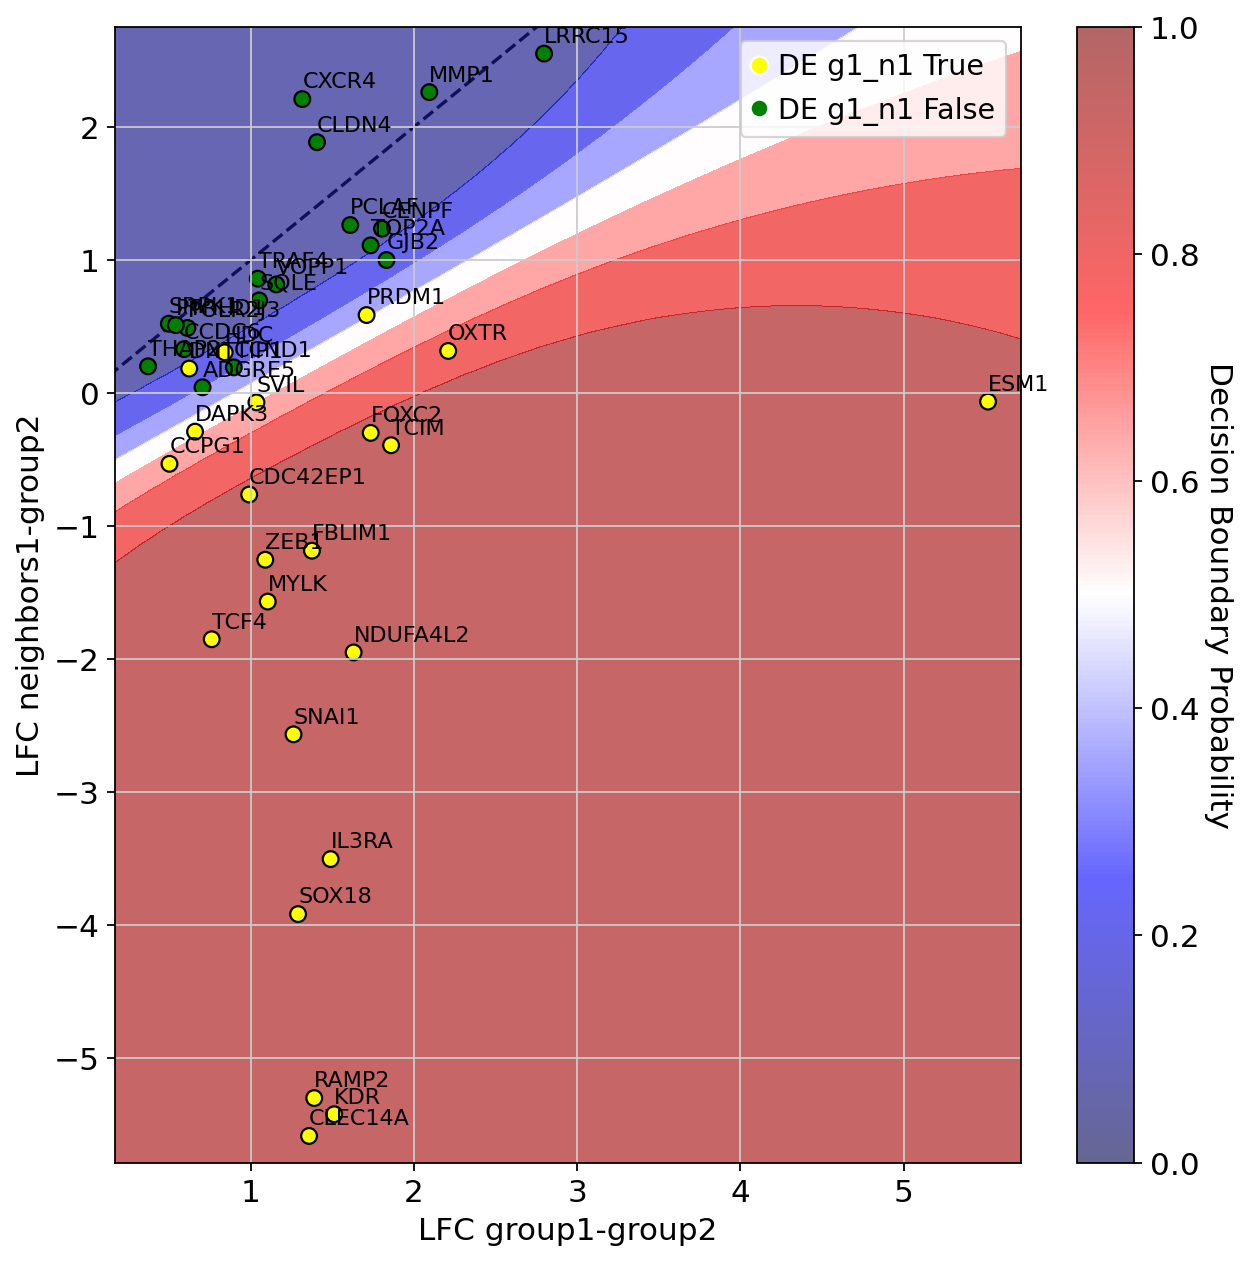

In [31]:
PLOT_MARGIN = 0.2

DE_1_0.plot(
    filter=g1_g3_genes,  # selected genes to plot
    # path_to_save="DE_plot.svg",
    margin=PLOT_MARGIN,  # margin around the plot
    legend_loc="upper right",  # location of the legend
)

You can select the marker genes (positive class for the classifier, yellow in the plot):

In [39]:
DE_1_0.gpc.confident_genes

Index(['ESM1', 'TCIM', 'PRDM1', 'ZEB1', 'OXTR', 'DNTTIP1', 'HDC', 'NDUFA4L2',
       'FBLIM1', 'SVIL', 'RAMP2', 'CDC42EP1', 'SOX18', 'KDR', 'DAPK3', 'FOXC2',
       'CLEC14A', 'IL3RA', 'CCPG1', 'TCF4', 'SNAI1', 'MYLK'],
      dtype='object')

We can also check the predicted class probabilities of the Gaussian process classifier:

In [33]:
DE_1_0.g1_g2["proba_de_g1_n1"].loc[DE_1_0.gpc.confident_genes]

ESM1        0.934383
TCIM        0.953926
PRDM1       0.433566
ZEB1        0.982689
OXTR        0.824434
DNTTIP1     0.174576
HDC         0.190277
NDUFA4L2    0.996999
FBLIM1      0.986999
SVIL        0.597059
RAMP2       0.972285
CDC42EP1    0.927882
SOX18       0.991716
KDR         0.970605
DAPK3       0.563717
FOXC2       0.928722
CLEC14A     0.965617
IL3RA       0.994964
CCPG1       0.672706
TCF4        0.990279
SNAI1       0.996836
MYLK        0.991079
Name: proba_de_g1_n1, dtype: float64

Then we can further filter the confident gene list, by setting a treshold on the classifier predictions - for instance 0.9:

In [40]:
DE_1_0.g1_g2["proba_de_g1_n1"].loc[DE_1_0.gpc.confident_genes][
    DE_1_0.g1_g2["proba_de_g1_n1"].loc[DE_1_0.gpc.confident_genes] > 0.9
].index

Index(['ESM1', 'TCIM', 'ZEB1', 'NDUFA4L2', 'FBLIM1', 'RAMP2', 'CDC42EP1',
       'SOX18', 'KDR', 'FOXC2', 'CLEC14A', 'IL3RA', 'TCF4', 'SNAI1', 'MYLK'],
      dtype='object')

Finally, we can plot spatial maps of the selected genes. We first compute global percentiles of the gene expression values to set an upper bound for the color scale.

In [35]:
def get_gene_percentiles_list(adata, gene_list, p, layer=None):
    """
    Calculate the p-percentile of gene expression for a list of genes in an AnnData object.

    Parameters
    ----------
        adata (AnnData): The AnnData object containing expression data.
        gene_list (list): List of gene names for which to compute percentiles.
        p (float): Percentile to compute (between 0 and 100).
        layer (str or None): The layer from which to retrieve expression data.
                             If None, uses `adata.X`.

    Returns
    -------
        list: A list of p-percentile values for the genes, in the same order as gene_list.
              If a gene is not found, its value will be `None`.
    """
    percentiles = []

    for gene in gene_list:
        if gene in adata.var_names:
            if layer:
                data = adata[:, gene].layers[layer].flatten()
            else:
                data = adata[:, gene].X.flatten()

            # Compute the percentile
            percentiles.append(np.percentile(data, p))
        else:
            percentiles.append(None)  # Handle genes not in adata.var_names

    return percentiles

We display _ESM1_, _KDR_, _SNAI1_, critical genes for angiogenesis in invasive cancer. We aslo display _FOXA1_, that is both upregulated in $\textit{G1}$ and $\textit{N1}$, to show how our procedure can filter such genes. 

In [36]:
gene_list_invasive = ["ESM1", "KDR", "SNAI1", "FOXA1"]
percentiles_invasive = get_gene_percentiles_list(
    adata, gene_list_invasive, 99.9, layer="min_max_scaled"
)

We first plot these genes in endothelial cells:

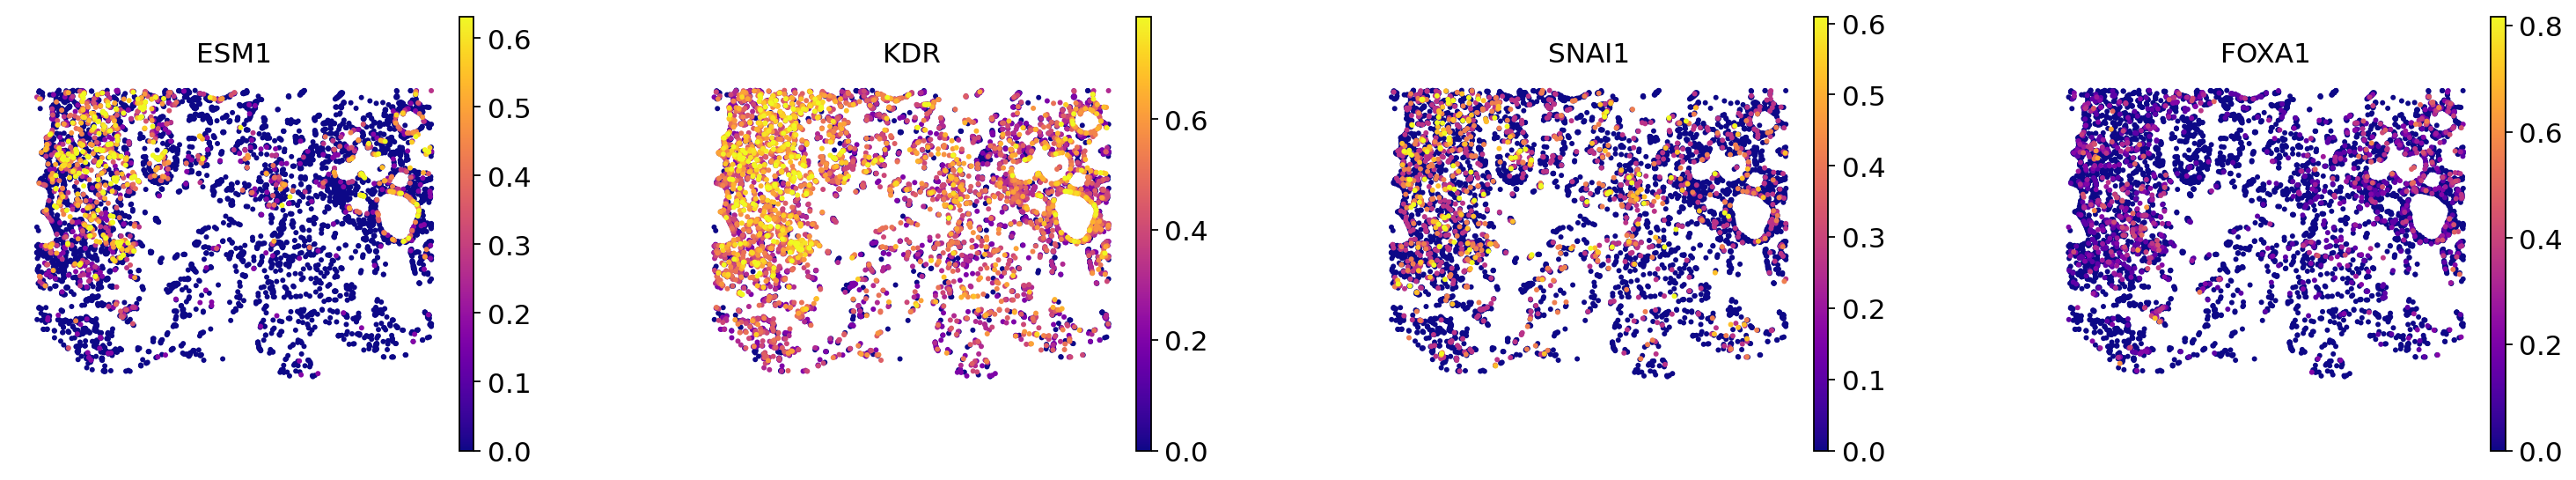

In [37]:
plot_endo = True

sc.pl.spatial(
    adata=adata_endothelial if plot_endo else adata_not_endo,
    spot_size=100 if plot_endo else 40,
    color=gene_list_invasive,
    frameon=False,
    use_raw=False,
    wspace=0.4,
    vmax=percentiles_invasive,
    layer="min_max_scaled",
    cmap="plasma",
)

Then in all cells but endothelial:

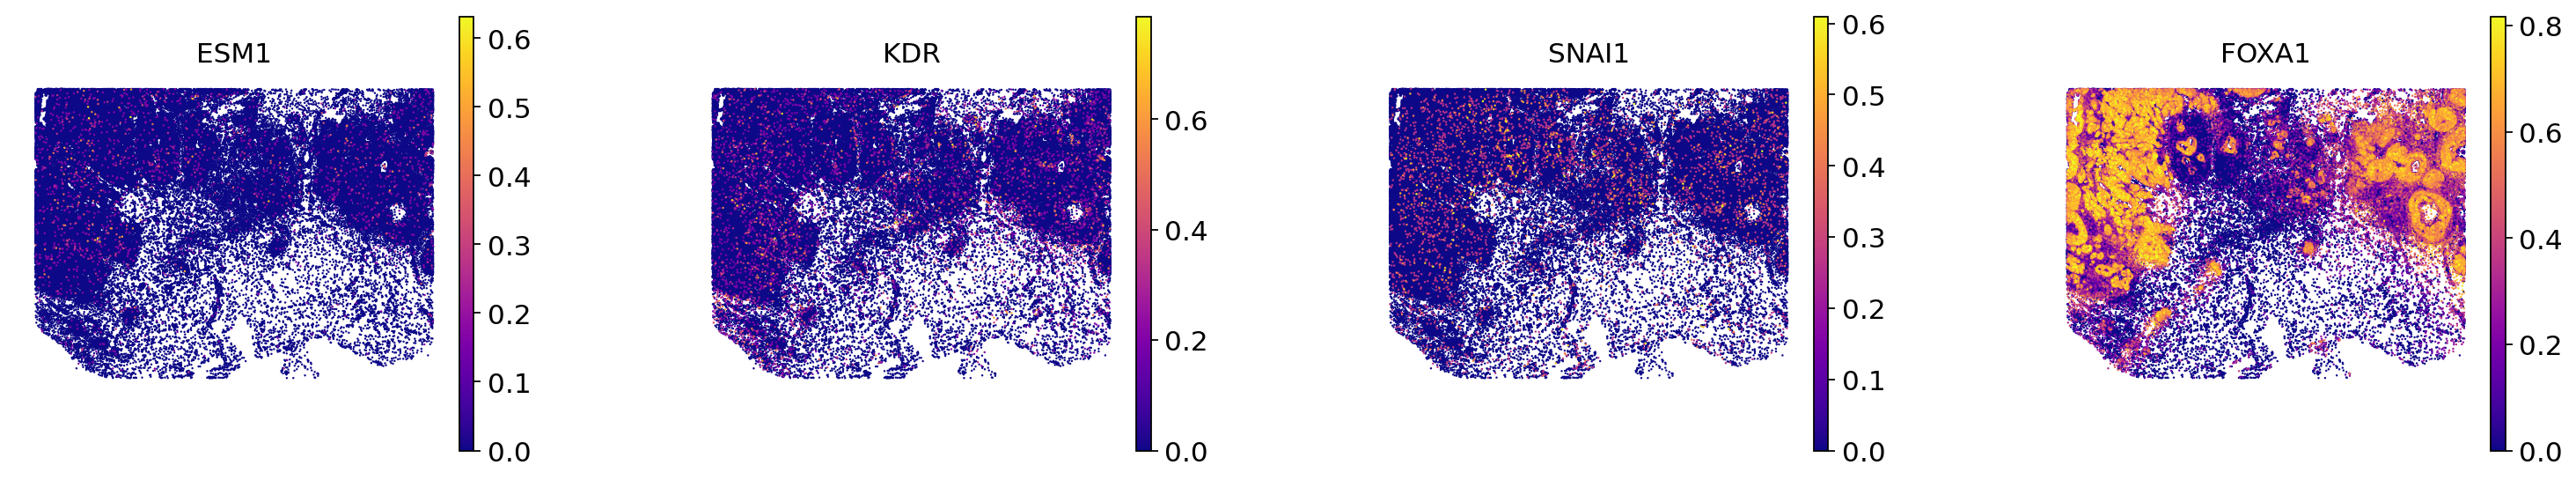

In [38]:
plot_endo = False

sc.pl.spatial(
    adata=adata_endothelial if plot_endo else adata_not_endo,
    spot_size=100 if plot_endo else 40,
    color=gene_list_invasive,
    frameon=False,
    use_raw=False,
    wspace=0.4,
    vmax=percentiles_invasive,
    layer="min_max_scaled",
    cmap="plasma",
)